In [2]:
from PIL import Image
import numpy as np

In [3]:
image_raw = Image.open("assets/cat.jpg")

In [4]:
IMG_SIZE = (1920,1080)

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

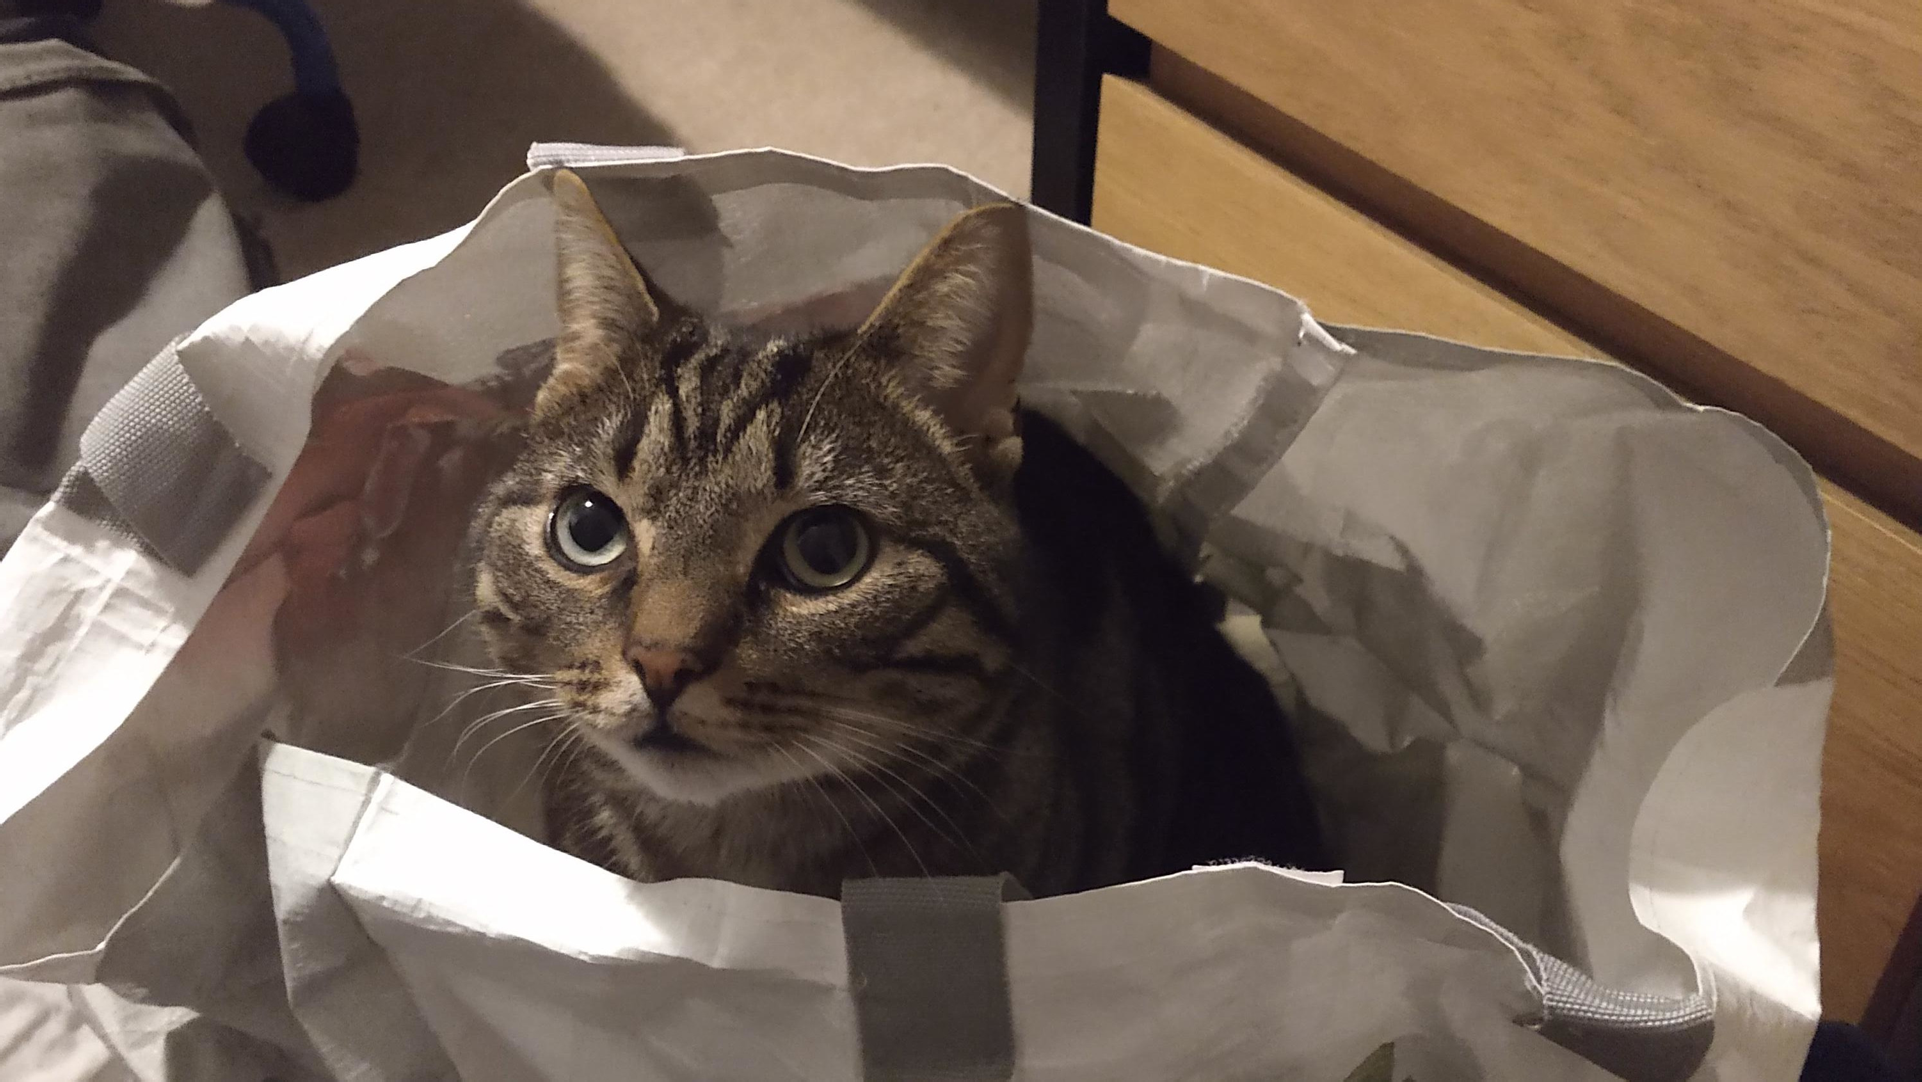

In [5]:
Image.fromarray(image_array_padded, 'RGB')

In [7]:
from pynq import Overlay
from pynq import allocate
#import pynq_sobel
import os
Kernel_Overlay = Overlay("general_filter_wrapper.bit")

In [8]:
Kernel_Overlay?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xaa8ba6e8>
File:            /usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay general_filter_wrapper.bit. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma              : pynq.lib.dma.DMA
general_filter_0     : pynq.overlay.DefaultIP
processing_system7_0 : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchie

In [9]:
#Input array for DMA use
kernel_in_dma_array  = allocate(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
kernel_out_dma_array = allocate(shape=(IMG_SIZE[1],IMG_SIZE[0]), dtype=np.uint32)

In [26]:
def do_conv(image_array,Kernel = [0.1, 0, 0, 0, 1, 0, 0, 0, 1], div = 1):
    # Set overlay threshold
    
    Kernel_Overlay.general_filter_0.write(0x20, Kernel[0]) #W00 
    Kernel_Overlay.general_filter_0.write(0x1C, Kernel[1]) #W01 
    Kernel_Overlay.general_filter_0.write(0x18, Kernel[2]) #W02
    Kernel_Overlay.general_filter_0.write(0x14, Kernel[3]) #W10
    Kernel_Overlay.general_filter_0.write(0x10, Kernel[4]) #W11
    Kernel_Overlay.general_filter_0.write(0x0C, Kernel[5]) #W12
    Kernel_Overlay.general_filter_0.write(0x08, Kernel[6]) #W20
    Kernel_Overlay.general_filter_0.write(0x04, Kernel[7]) #W21
    Kernel_Overlay.general_filter_0.write(0x00, Kernel[8]) #W22
    Kernel_Overlay.general_filter_0.write(0x24,       div) #Matrix division
    # Copy image array into dma buffer
    kernel_in_dma_array[:, :, :3] = image_array[:, :, :]
    
    Kernel_Overlay.axi_dma.recvchannel.transfer(kernel_out_dma_array)
    Kernel_Overlay.axi_dma.sendchannel.transfer(kernel_in_dma_array)

    Kernel_Overlay.axi_dma.sendchannel.wait()
    Kernel_Overlay.axi_dma.recvchannel.wait()
    
    return kernel_out_dma_array

In [27]:
Kernel = [0,-1,0,-1,5,-1,0,-1,0]
div = 1

In [28]:
%time image_output = do_conv(image_array_padded,Kernel,div)

CPU times: user 379 ms, sys: 10.7 ms, total: 390 ms
Wall time: 493 ms


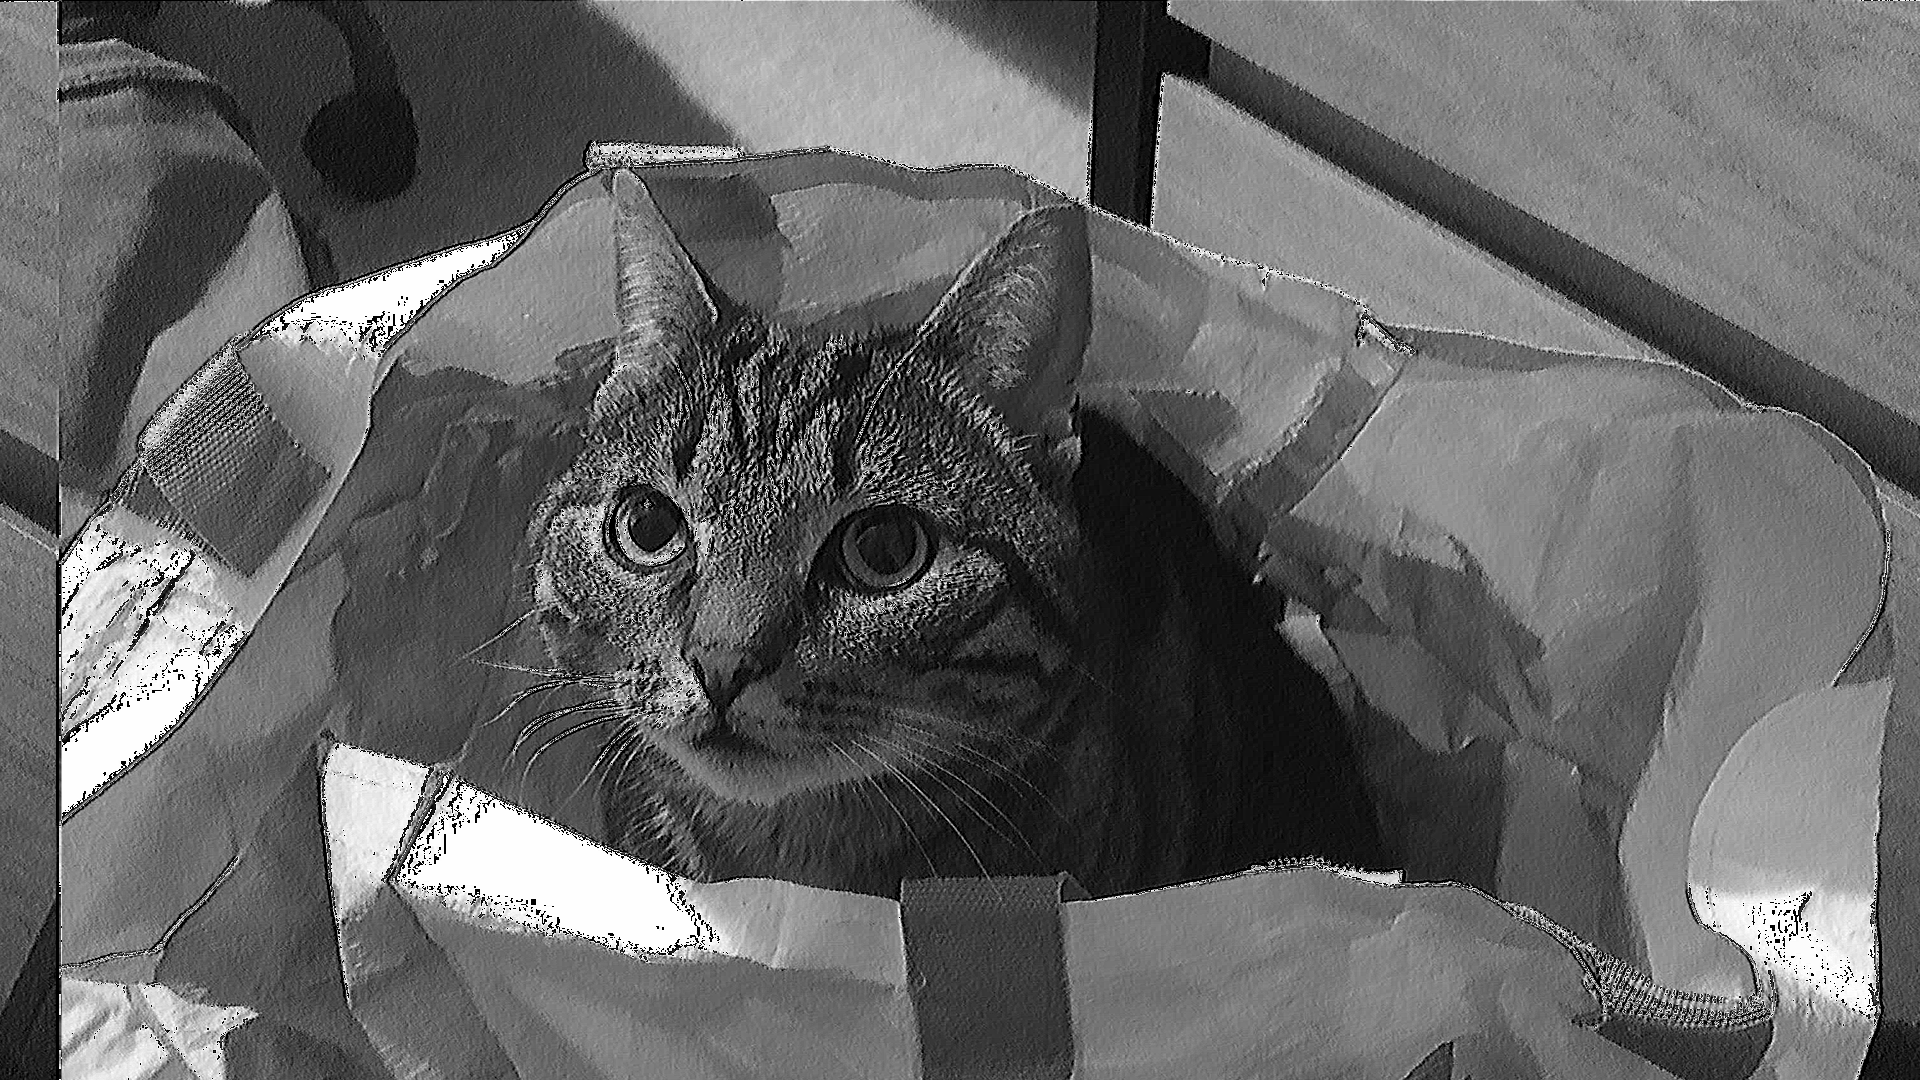

In [29]:
Image.fromarray(np.uint8(image_output), mode='P')